# Introduction



In this post, I explore data on the dams that supply the City of Cape Town (CoCT) and offer predictions on how long we have until the levels collapse and how long until they are replenished. The data are available publicy at the City of Cape Town's Open Data Portal [here](https://web1.capetown.gov.za/web1/opendataportal/DatasetDetail?DatasetName=Dam+levels). The original and cleaned datasets are also available in the [repo](https://github.com/jbertscher/dam-levels) housing this script, along with a script used to generate the processed version. I downloaded the data on 12 Dec 2017 but it seems to be updated from time to time.

There are 4 sections to this notebook. Each addresses a different problem. In summary:
1. I estimate that 'day zero' will occur around 16 May 2018 at the time of writing, assuming current consumption levels and that the government does not step in before then (which they will).
2. At current consumption levels, 362,651ML is the absolute minimum dam level needed going into next summer to avoid running out of water.
3. If we run out of water this year but have a good rainy season, we could expect the dams to reach the minimum required level to avoid running out next summer - 362,651ML, as mentioned in (2) above - in 4 months. In a bad year, it could take at least 2 rainy seasons.
4. If we want to have enough water in the dams to have some backup in case we have another bad winter, we need at least 442,651ML in the dams at the start of the next dry season in October this year. We could achieve this with one good wet season.

Where "ML" means megalitre, or a million litres.

In [1]:
%matplotlib inline

import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from textwrap import wrap

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Read and prep dam level data
dam_levels = pd.read_csv('data/processed/Dam-levels-clean-20120101-20171206.csv', encoding = 'latin1')
dam_levels['date'] = pd.to_datetime(dam_levels['date'])
# Read and prep aggregated dam level data
agg_storage_ml = pd.read_csv('data/processed/agg-storage-ml.csv')
agg_storage_ml['date'] = pd.to_datetime(agg_storage_ml['date']).dt.date
agg_storage_ml.index = agg_storage_ml['date']
agg_storage_ml.index.name = 'date'

TOTAL_DAM_CAPACITY = 902598  # Total dam capacity 
DAM_LEVEL_PCT = 0.297
AVG_CT_CONSUMPTION = 559

# The Crisis

The graph below shows the dam levels for each day in the dataset (going back to 2012), with the red line marking the *usable* storage limit (10% of each dam's capacity is 'unavailable' because it's extraction is not feasible). From this, we can see just how dangerously close we are coming to running out of water. The 2017 winter rains have helped to prop up the dam levels somewhat, but it's easy to see that the drop between October and April 2016 is far greater than the available storage at the height of the dam levels in October 2017 - the same drop this season and we run out of water.

This graph also highlights how insidious the draught has been. The winters between 2012 and 2015 saw the dam levels reaching capacity. As late as 2014, the level didn't drop below 75% of their capacity in the summer. This shows how unexpected and novel the current situation is. It's not as if the levels have been slowly decreasing each year for many years. It's only from 2015 that we see the dry winters and long summers starting to take their toll. Moreover, the current year's rainy season has been dreadful, compared even to the last 2 years.

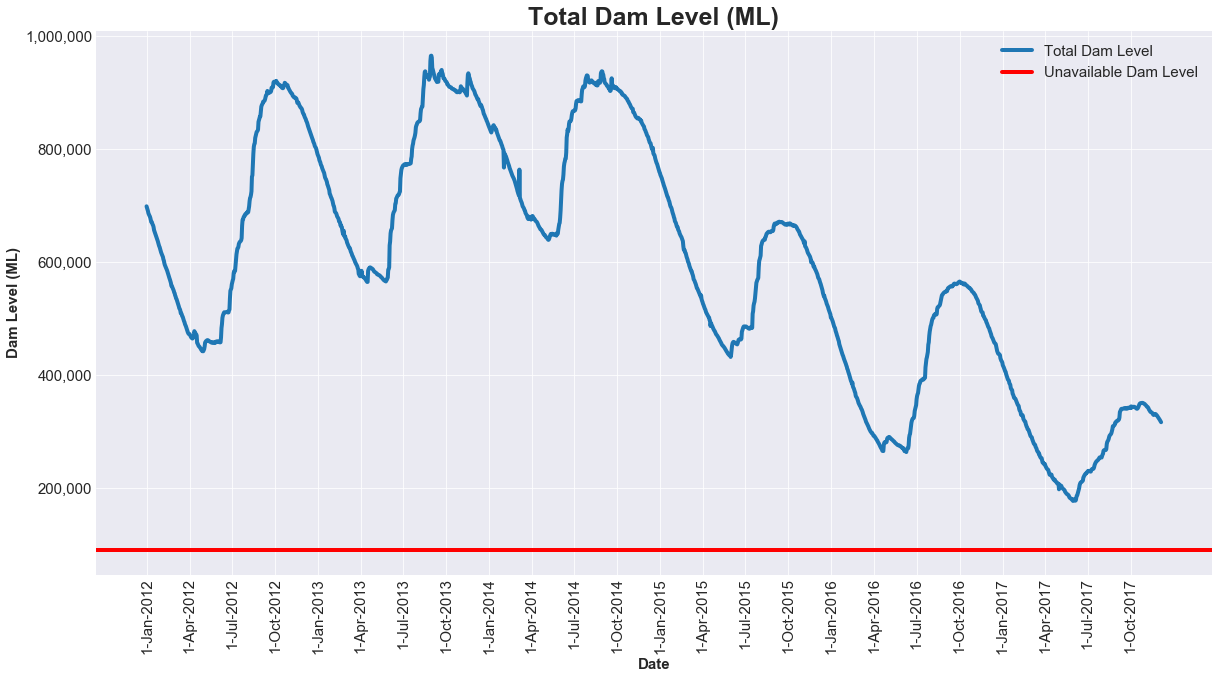

In [2]:
sns.set_style("darkgrid")  # Sets style for pyplot graphs to match seaborn

fig, ax = plt.subplots(figsize=[20,10]) # [w, h]
plt.plot(range(len(agg_storage_ml)), agg_storage_ml['storage_ml'], label = 'Total Dam Level', linewidth = 4)
ax.axhline(y = 0.1 * TOTAL_DAM_CAPACITY,  label = 'Unavailable Dam Level',  c = 'red', linewidth = 4)

# In the plot that follows, we'll want to be smart about how we label the x-axis. Too many labels will make it 
# unreadable but having too few will make it more difficult to see what date period we're looking at. 
# Generally we'll want to plot the 1st date of every month at a particular interval. We need to calculate an 
# associated index, which will tell the plotting library where to place the labels - that's what the `dayofyear` 
# and `cumsum_dayofyear` columns are doing in the dataframe below.
first_day_of_month = dam_levels.loc[(dam_levels['dayofmonth'] == 1), ['date', 'month', 'daymonthyear']].drop_duplicates()
first_day_of_month['lag_date'] = first_day_of_month['date'].shift(periods = 1)
first_day_of_month['cumsum_dayofyear'] = (first_day_of_month['date'] - first_day_of_month['lag_date']).dt.days.cumsum().fillna(0) + 1
first_day_of_quarter = first_day_of_month[first_day_of_month['month'].isin([1, 4, 7, 10])]

plt.title('Total Dam Level (ML)', fontsize = 25, fontweight = 'bold');
plt.xticks(first_day_of_quarter['cumsum_dayofyear'], first_day_of_quarter['daymonthyear'], rotation = 90, fontsize = 15);
plt.xlabel('Date', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15)
plt.ylabel('Dam Level (ML)', fontsize = 15, fontweight = 'bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# plt.ylim(ymin = 0)
plt.legend(fontsize = 15)
plt.show();

The crisis also isn't only a problem of not enough rain in the rainy season but also too much *net* water consumption - the drawdown of the dams less any additional water through summer rains and the like - in the dry seasons. In particular, the 2015 summer was particularly bad, depleting dam storage by more than 50% more than in the previous year. The table below gives us some more insights.

In [3]:
# Find values at start of 'wet season' - defined here as when dam levels are at their minimum
min_storage = agg_storage_ml.loc[agg_storage_ml.groupby('year')['storage_ml'].idxmin(), ['year', 'storage_ml']]
min_storage = min_storage.reset_index()[['year', 'date', 'storage_ml']]
min_storage = min_storage.rename(columns = {'date': 'wet_season_start_date',
                                           'storage_ml': 'start_storage_ml'})

# Find values at end of 'wet season' - defined here as when dam levels are at their maximum (after wet season has begun)
max_storage = pd.merge(agg_storage_ml, min_storage, on = ['year'])
max_storage.index = max_storage['date']
max_storage = max_storage.loc[max_storage['date'] > max_storage['wet_season_start_date']]  # Must make sure we're looking for max level AFTER start of wet season
max_storage = max_storage.loc[max_storage.groupby('year')['storage_ml'].idxmax(), ['year', 'storage_ml']]
max_storage = max_storage.reset_index()[['year', 'date', 'storage_ml']]
max_storage = max_storage.rename(columns = {'date': 'wet_season_end_date',
                                           'storage_ml': 'end_storage_ml'})

# Combine data for start and end of wet season
season_summary = pd.merge(min_storage, max_storage, on = ['year'], copy = False)
season_summary = season_summary.rename(columns = {'date': 'wet_season_start_date'})

# Length of wet and dry seasons, respectively (days)
season_summary['wet_season_length'] = (season_summary['wet_season_end_date'] - season_summary['wet_season_start_date']).dt.days  
season_summary['dry_season_length'] = (season_summary['wet_season_start_date'] - season_summary['wet_season_end_date'].shift(periods = 1)).dt.days

# Find change in storage over dry and wet seasons respectively
season_summary['wet_season_change'] = season_summary['end_storage_ml'] - season_summary['start_storage_ml'] 
season_summary['dry_season_change'] = season_summary['start_storage_ml'] - season_summary['end_storage_ml'].shift(periods = 1)

# Reorder columns
season_summary = season_summary[['year', 'wet_season_start_date', 'wet_season_end_date', 'start_storage_ml', 
                        'end_storage_ml', 'wet_season_change', 'dry_season_change', 
                         'wet_season_length', 'dry_season_length']]

# Combine data on start and end of wet season back to daily storage during wet season
wet_season_storage = pd.merge(agg_storage_ml, season_summary, on = ['year'])
wet_season_storage = wet_season_storage[(wet_season_storage['date'] >= wet_season_storage['wet_season_start_date']) &
                       (wet_season_storage['date'] <= wet_season_storage['wet_season_end_date'])]



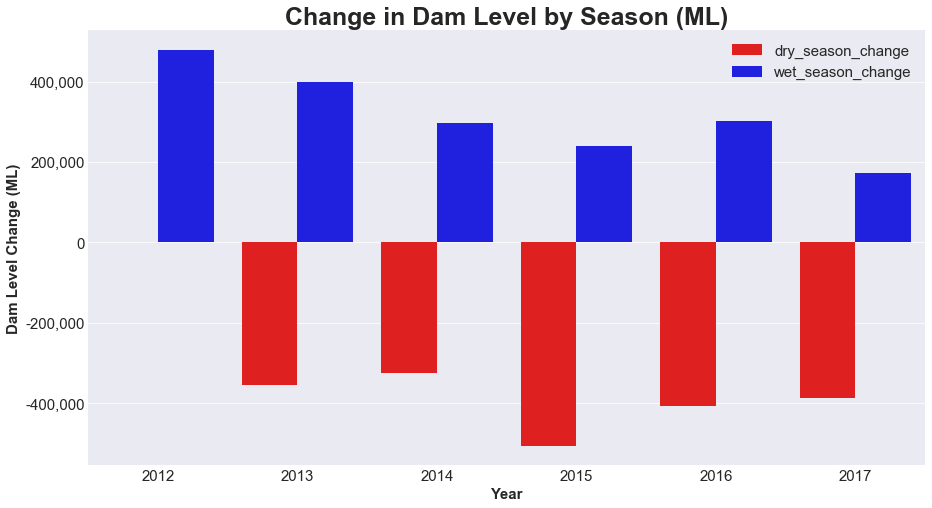

In [4]:
# Melt `wet_season` for seaborn boxplot
season_summary_melt = pd.melt(season_summary[['year', 'dry_season_change', 'wet_season_change']], 
                          id_vars = 'year', var_name = 'season', value_name = 'storage_change')

fig, ax = plt.subplots(figsize = (15,8))
sns.barplot(x = 'year', y = 'storage_change', hue = 'season', data = season_summary_melt, palette = ['red', 'blue'])
plt.title('Change in Dam Level by Season (ML)', fontsize = 25, fontweight = 'bold')
plt.xlabel('Year', fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 15)
plt.ylabel('Dam Level Change (ML)', fontsize = 15, fontweight = 'bold')
plt.xticks(fontsize = 15)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.legend(fontsize = 15)
plt.show();

We can see from the below table that the wet seasons from 2015 to 2017 started in June, much later than 2012 and 2013, where it started in April and May. The wet seasons were also much shorter on average during the 3 years following 2013 (104-114 days), than the 2 years before (137-156 days). 

In [5]:
season_summary.style.format({
    'start_storage_ml': '{:,.0f}'.format,
    'end_storage_ml': '{:,.0f}'.format,
    'wet_season_change': '{:,.0f}'.format,
    'dry_season_change': '{:,.0f}'.format,
})

,year,wet_season_start_date,wet_season_end_date,start_storage_ml,end_storage_ml,wet_season_change,dry_season_change,wet_season_length,dry_season_length
0,2012,2012-05-01,2012-10-04,"441,568","919,933","478,366",nan,156,nan
1,2013,2013-04-16,2013-08-31,"564,195","964,590","400,395","-355,738",137,194
2,2014,2014-05-08,2014-08-30,"638,676","936,987","298,311","-325,914",114,250
3,2015,2015-06-01,2015-09-13,"431,543","670,787","239,244","-505,444",104,275
4,2016,2016-06-10,2016-10-02,"263,272","564,967","301,696","-407,515",114,271
5,2017,2017-06-01,2017-10-28,"176,777","350,279","173,501","-388,190",149,242


We only have data from 2012 onwards so we can't say whether the 2012-2013 wet seasons are representative of previous years. It may well be that they are an anomaly and that previous years were much better or worse. However, it provides context for the more recent dam levels and suggests that our current predicament is a product of a pattern that deviates from a better-case scenario. Analysis of weather conditions that span a greater time-frame could supplement this view but I'll leave that for another time.

# 1. When will we run out of water?

There have been estimates for when the city will run out of water (ominously termed 'Day Zero') - notably from the [CSAG](http://www.csag.uct.ac.za/2017/10/24/waiting-for-the-rain/), the [City of Cape Town (CoCT)](http://coct.co/water-dashboard/), and [this](http://www.howmanydaysofwaterdoescapetownhaveleft.co.za/) website. While the latter 2 don't disclose how they arrived at their numbers, the first, written by Piotr Wolski at CSAG does. My approach will follow his logic. My contribution here will be in providing an updated figure, based on current dam levels and usage stats.

Let's assume that there are no meaningful inflows of water into the dams during the summer period. Then we can work out the number of days of water we have left with this simple formula:
$$d = {s \over c}$$

where:
+ d = number of days remaining
+ s = current storage of water in the dams
+ c = average daily water consumption

The CoCT publishes a ["water dashboard"](https://resource.capetown.gov.za/documentcentre/Documents/City%20research%20reports%20and%20review/damlevels.pdf) - I've saved the latest one at the time of writing (published 8 January) [here](resources/damlevels.pdf), which states that the total volume of dammed water is currently at 29.7% or 268,072ML. However, the last 10% of the water is unusable, since it becomes impossible to extract. The total capacity is 902,598Ml, which means that we need to subtract 90,260Ml, leaving us with 177,811ML remaining. 

In [6]:
remaining_storage = DAM_LEVEL_PCT * TOTAL_DAM_CAPACITY
min_usable_storage = 0.1 * TOTAL_DAM_CAPACITY
remaining_usable_storage = remaining_storage - min_usable_storage

print('Remaining storage (ML): {:,.0f}'.format(remaining_storage))
print('Unusable storage (ML): {:,.0f}'.format(min_usable_storage))
print('Remaining usable storage (ML): {:,.0f}'.format(remaining_usable_storage))

Remaining storage (ML): 268,072
Unusable storage (ML): 90,260
Remaining usable storage (ML): 177,812


The same source shows daily consumption by the City at 559ML per day. So we almost have everything we need to plug in to the above formula and solve for the days. However, we only have the *City's* consumption. According to the Water & Sanitation Department, CoCT's share of total water consumption is only 40%. This is illustrated in the chart below, which can be found [here](https://www.groundup.org.za/media/uploads/documents/BusinessBriefingOnWaterCrisis9MayPeterFlowerPresentationHandout.pdf):

<div id = 'inner' style='width:350px', margin = 0 auto>
<br>
![water-use-wcwss](./resources/waterusewcwss.png)
<br>
</div>

So if we want to get the *total* water consumption, we need to scale up the the consumption by a factor of $100/40 = 2.5$. This means that total consumtpion is 1,398ML per day. Using this figure, and we have $177,812/1,398 = 127$ days left. This puts 'day zero' at 16 May 2018, which is 2 days later than the website http://www.howmanydaysofwaterdoescapetownhaveleft.co.za/. The City has esimated that they will switch off the taps on 22 April, before we actually have nothing left in the dams. They estimate day zero to be around 5 July, but this assumes that taps are switched off before and a strict rationing system implemented.

The City has set a water consumption target of 500ML, 59ML less than the current levels. At that consumption rate, our simple model would predict Day Zero to fall on 31 May 2018, which is generally the end of the dry season. Even if we achieved these targets and the rains arrived, it would still take time for the dams to be replenished and at such levels that we would not have a repeat of the prospect of running out of water next season. The following 2 sections deal with what dam levels we need at the beginning of the dry season in October this year and how long it will take to reach that level.

In [7]:
def day_zero(consumption):
    avg_tot_consumption = 2.5 * consumption 
    days_left = remaining_usable_storage/avg_tot_consumption
    day_zero_date = (datetime.date(year = 2018, month = 1, day = 9) + datetime.timedelta(days = days_left)).strftime('%Y-%m-%d')
    return [avg_tot_consumption, days_left, day_zero_date]

scenarios = {'current (559ML)': day_zero(AVG_CT_CONSUMPTION),
             'target (500ML)': day_zero(500)}

for k, c in scenarios.items():
    print('''
    At {0} water consumption:
    - days left: {1:,.0f}
    - day zero: {2}
    '''.format(k, c[1], c[2]))



    At target (500ML) water consumption:
    - days left: 142
    - day zero: 2018-05-31
    

    At current (559ML) water consumption:
    - days left: 127
    - day zero: 2018-05-16
    


# 2. How much water do we need at the beginning of summer?

How much water do we need in the dams at the beginning of summer to last us through the season, until the winter rains come? This, of course, depends on how much water we use. I will attempt to answer this question given historical, current, and target water usage scenarios.

If we again assume that there will be no meaningful inflows of water into the dams during the dry season, we can can just rearrange the equation above and solve for *s* - the total storage needed is the sum of all the water consumed each day over all the days in the dry season: 
$$s = d \times c$$

Eyeballing the dam storage graph above, we can see that dam levels tend to drop off from between the beginning of October to the latter half of June. Let's use the average number of days in the dry seasons in the past 4 years to be conservative. That gives us about 260 days.

In [8]:
dry_season_days = season_summary.loc[season_summary['year'] >= 2014, 'dry_season_length'].mean()
dry_season_days

259.5

The consumption level is a parameter that we'll need to assume. If we assume current consumption levels, plugging in to our equation above, we get $s = 260 * 1398 = 362,651$. We can do the same for different consumption levels. The results are displayed in the table below:

In [9]:
storage_needed = pd.DataFrame()
storage_needed['CoCT Avg Daily Consumption'] = [500, AVG_CT_CONSUMPTION, 600]
storage_needed['Total Avg Daily Consumption'] = 2.5 * storage_needed['CoCT Avg Daily Consumption']
storage_needed['Storage Needed'] = dry_season_days * storage_needed['Total Avg Daily Consumption']
storage_needed_current_cons = storage_needed.loc[storage_needed['CoCT Avg Daily Consumption'] == AVG_CT_CONSUMPTION, 
                                             'Storage Needed']
storage_needed.style.format('{:,.0f}')

,CoCT Avg Daily Consumption,Total Avg Daily Consumption,Storage Needed
0,500,"1,250","324,375"
1,559,"1,398","362,651"
2,600,"1,500","389,250"


# 3. How long will it take for the dams to replenish before next summer?

The wet season brings rains, which will cause dam levels to increase. Generally, there are enough rains each year that we don't need to worry about running out by the end of the proceeding dry season. However, that is not a given. If we assume that we have no water left by the end of the current dry season, can the dams be replenished in one season? This assumes, of course, that no additional water is added to the system. We know that the City has plans in place to supplement the water naturally supplied by the rains. In this section, we will also predict how much they will need to supply if needed.

I will assume that the daily average consumption remains sy 559ML per day so that we need 362,651ML at the beginning of summer to just have enough water, which we worked out in the previous section. If we completely run out of water by the end of the dry season in the middle of this year, how long will it take us to get back to the required level? One way we can attempt to answer this is by fitting a line to the dam levels relative to the start of the rainy season each year and see how long it takes that line to reach the needed level. Let's do this separately for 2012-2013 ('good season'), 2014-2016 ('bad season'), and 2017 (which is in a dismal league of it's own - 'worse season')

To be conservative, I'm going to assume that the beginning of the wet season is when the dams are at their minimum levels for the year and the end of the wet season is the day the maximum dam storage is reached after the rainy season has begun.

In [10]:
# Get change in storage for each year relative to beginning of each year's wet season
aligned_wet_seasons = {}
relative_wet_seasons = pd.DataFrame()
for y in list(range(2012,2018)):
    season = pd.DataFrame()
    season['date'] = wet_season_storage.loc[wet_season_storage['year'] == y, 'date']
    season['season_day'] = list(range(len(season['date'])))  # Get day relative to start of season
    # Get change in storage (subtracting level at beginning of season)
    season['storage_ml'] = (wet_season_storage.loc[wet_season_storage['year'] == y, 'storage_ml'] - wet_season_storage.loc[wet_season_storage['year'] == y, 'start_storage_ml']).tolist()
    aligned_wet_seasons[y] = season
    relative_wet_seasons = pd.concat([relative_wet_seasons, season], axis = 0)
    
# Fit 3-degree polynomials for different years (representing different scenarios)
# Then estimate dam levels n days after start of season under each scenario

# Good season
relative_wet_seasons_good = relative_wet_seasons[pd.to_datetime(relative_wet_seasons['date']).dt.year.isin([2012, 2013])]
f = np.polyfit(relative_wet_seasons_good['season_day'], relative_wet_seasons_good['storage_ml'], deg = 3)
good_season_fit = np.poly1d(f)
good_season_fitted = good_season_fit(relative_wet_seasons_good['season_day'])

# Bad season
relative_wet_seasons_bad = relative_wet_seasons[pd.to_datetime(relative_wet_seasons['date']).dt.year.isin([2014, 2015, 2016])]
f = np.polyfit(relative_wet_seasons_bad['season_day'], relative_wet_seasons_bad['storage_ml'], deg = 3)
bad_season_fit = np.poly1d(f)
bad_season_fitted = bad_season_fit(relative_wet_seasons_bad['season_day'])

# Worst season
relative_wet_seasons_worst = relative_wet_seasons[pd.to_datetime(relative_wet_seasons['date']).dt.year.isin([2017])]
f = np.polyfit(relative_wet_seasons_worst['season_day'], relative_wet_seasons_worst['storage_ml'], deg = 3)
worst_season_fit = np.poly1d(f)
worst_season_fitted = worst_season_fit(relative_wet_seasons_worst['season_day'])

The plot below shows fitted lines for:
+ Good rainy seasons (2012-2013) in blue
+ Bad rainy seasons (2014-2016) in orange
+ Worst rainy seasons (2017) in red

The dotted horizontal line is the minimum level that needs to be reached going into summer so that we don't run out (assuming current consumption levels). This will only be reached in the good-case scenario, in which case we can expect it to be achieved in about 130 days. In the other scenarios, the requisite levels won't be reached in one season. In the bad scenario, levels reach about 280,000ML, which means that the City will need to add at least approximately 83,000ML into the system. In the worst-case scenario, we only reach a dam level of 170,000ML by the end of the rainy season, which means that the City will have to find an additional 193,000ML. This is a staggering amount - about 24% of the total usable storage in the entire system! 

We should be reminded here that this assumes that we run out of water at the end of the current (2017-2018) dry season. This might not happen due to additional supply by the City, water conservation, or additional restrictions. Given what's at stake, these will be necessary. 

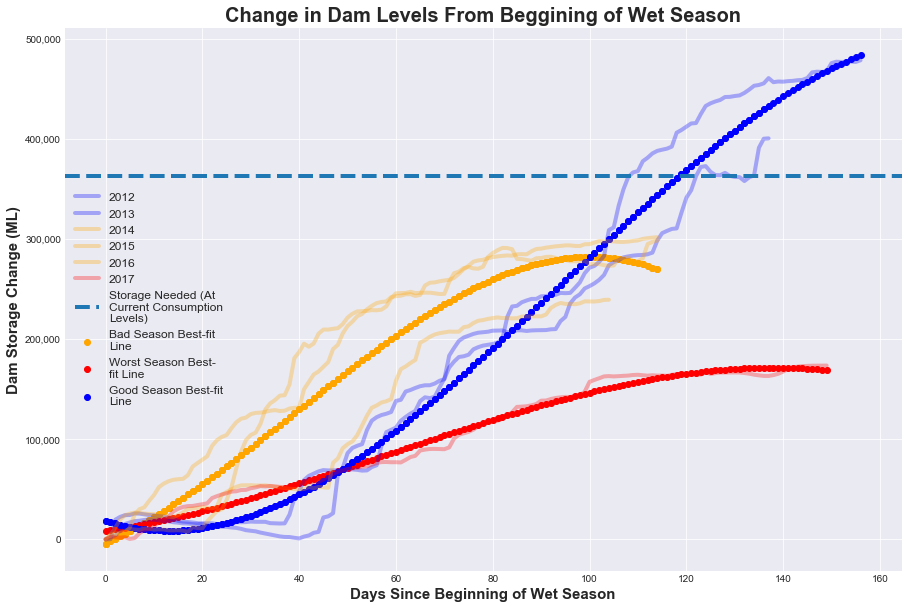

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
# Blue will represent good years, orange bad years, and red the worst years
colours = [
    'blue',
    'blue',
    'orange',
    'orange',
    'orange',
    'red',
]

# Plot actual wet season dam level differences relative to start of the year
y = list(range(2012,2018))
for i, y in enumerate(y):
    plt.plot(aligned_wet_seasons[y]['season_day'], aligned_wet_seasons[y]['storage_ml'], label = y, 
             c = colours[i], linewidth = 4, alpha = 0.3)

# Plot water level needed going in to summer (at current consumption)
ax.axhline(float(storage_needed_current_cons), linewidth = 4, 
           label = 'Storage Needed (At Current Consumption Levels)', linestyle = '--')

# Plot fitted lines
plt.scatter(relative_wet_seasons_bad['season_day'], bad_season_fitted, 
            c = 'orange', label = 'Bad Season Best-fit Line')
plt.scatter(relative_wet_seasons_worst['season_day'], worst_season_fitted, 
            c = 'red', label = 'Worst Season Best-fit Line')
plt.scatter(relative_wet_seasons_good['season_day'], good_season_fitted, 
            c = 'blue', label = 'Good Season Best-fit Line')

plt.title('Change in Dam Levels From Beggining of Wet Season', fontsize = 20, fontweight = 'bold')
plt.xlabel('Days Since Beginning of Wet Season', fontsize = 15, fontweight = 'bold', )
plt.ylabel('Dam Storage Change (ML)', fontsize = 15, fontweight = 'bold')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

handles, labels = ax.get_legend_handles_labels()
labels = [ '\n'.join(wrap(lab, 20)) for lab in labels]
ax.legend(labels, fontsize = 12)

plt.show();

In [12]:
scenarios = {'Good': good_season_fitted.max(), 'Bad': bad_season_fitted.max(), 'Worst': worst_season_fitted.max()}
print('Different wet season scenarios:')
for k, c in scenarios.items():
    print()
    print('- {0} season:'.format(k))
    print('. Maximum level reached (ML): {0:,.0f}'.format(c))
    short_fall = float(storage_needed_current_cons) - c
    print('. Shortfall (ML): {0:,.0f} ({1:.0%})'.format(short_fall, short_fall/TOTAL_DAM_CAPACITY))

Different wet season scenarios:

- Good season:
. Maximum level reached (ML): 483,273
. Shortfall (ML): -120,622 (-13%)

- Bad season:
. Maximum level reached (ML): 282,267
. Shortfall (ML): 80,384 (9%)

- Worst season:
. Maximum level reached (ML): 171,405
. Shortfall (ML): 191,246 (21%)


# 4. What dam level is sustainable and how long will it take to achieve it?
We have already seen how much water we need for one dry season and how long it will take to get there under different scenarios. But how long would it take to reach a 'sustainable' level of dam storage? By *sustainable*, I mean that we have enough water to last us, not only through the impending summer season, but enough to comforably last us into the next dry season as well. It will take a while for dam levels to reach capacity but we can at least rest a little esaier when we know that we have some lee-way. We don't know what is going to happen in the future and to be so dependent on one good season is probably not a reliable strategy. A different way of formulating this question is, *how much water do we need such that __if we have another bad winter__, we don't run out of water the following summer*. This will depend on water usage throughout winter, as well as how much water finds it's way into the system throughout the period. 

Let's assume, as calculated above, that we need at least 362,651ML in the dams at the beginning of the 2019 dry season to last us through. Assuming we run out of water this season, we have already seen that a bad rainy season won't even get us to a dam level sufficient to see us through one summer. After a good rainy season, however, we can expect a maximum uplift in dam levels of 483,273ML and this would allow some left-over water to supplement the uplift from the 2019 rainy season. If the 2019 rainy season turned out to be bad, we would have a 80,000ML shortfall, which we calculated in the previous section (362,651ML needed less the 282,267ML expected in a bad season). We need to add this amount the requisite 362,651ML need for the 2018 dry season so that we have that amount left over to 'top up' the dams and avoid running out in 2019. This totals 442,651ML. We *could* reach that level if we have one good season, which is some positive news.

# Conclusion

The situation truly does look bleak. However, I have made simplifying assumptions about water consumption throughout this notebook. The City has indicated that they have plans to mitigate and handle the situation as dam levels drop. This includes turning off the taps before we run out of water completely. This will affect the estimates here. There are also plans to add additional water to the system, by tapping into aquifers and desalination. Most importantly, it's what *we do* that will ultimately affect the outcome - in terms of how much we consume going forward. In particular, the dam level trends that I outline assume that consumption in the future will be the same as the past, in both summer and winter months. Behaviours have already changed so the numbers here are probably conservative and may paint a bleaker picture than may actually transpire.

That being said, to reiterate the *current* state of affairs:
1. I estimate that 'day zero' will be around 16 May 2018 at the time of writing at current consumption levels (if there were no intervention by the City).
2. At current consumption levels, 362,651ML is the absolute minimum dam level needed going into next summer to avoid running out of water.
3. In a good year rainy season, we would reach the minimum required dam level mentioned in (2) in 4 months. In a bad year, it would take at least 2 years.
4. If we want to have enough water in the dams to have some backup in case we have another bad winter, we need at least 442,651ML in the dams at the start of the next dry season in October this year. We could achieve this with one good wet season.